This Notebook will guide you through the simulation and analysis of near-infrared (NIR) high-resolution spectroscopy (HRS) data of exoplanet atmospheres. 

## Part 1 - The simulator

In this first part we will simulate a typical spectral sequence as observed by the CRIRES spectrograph at the Very Large Telescope. Values and parameters are based on typical performances of the instrument, but they can be tweaked by the user to verify their influence on the final retrieved signals.

In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import simulator_code as sim

To simulate the planet signal we will use a high-resolution spectrum computed for a hot Jupiter like HD 209458 b (1.38 <i>R</i><sub>Jup</sub>, 0.71 <i>M</i><sub>Jup</sub>), orbiting a G0V star in about 3.5 days at 0.045 AU. The modelled thermal emission of this planet includes opacities from CO only.

In [2]:
wMod = np.load('wmod.npy')
fMod = np.load('fmod.npy')

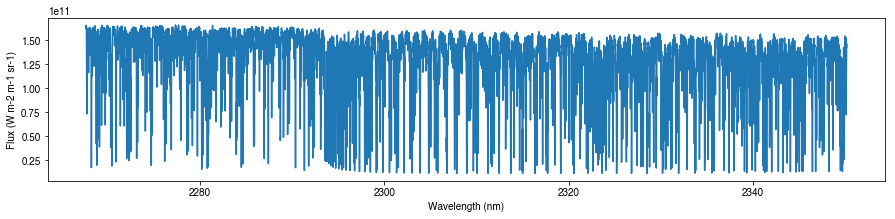

In [3]:
plt.figure(figsize=(15,3))
plt.plot(wMod, fMod)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux (W m-2 m-1 sr-1)')
plt.show()

Since in the majority of exoplanet observations we do not separate the planet light from the host-star light, we want to express the planet spectrum in units of stellar spectrum. We will approximate the star as a black body at temperature <i>T</i><sub>eff</sub> = 6070 K, which is appropriate in the $K$ band except for possible shallow CO stellar lines. The scaling will be:
$$ F_\mathrm{scaled} = \frac{F_\mathrm{model}}{BB(\lambda,T_\mathrm{eff})} \left( \frac{R_P}{R_\star} \right)^2 $$
Our pipeline contains a function that performs the scaling:

In [6]:
extraScaling = 2
fModScaled = sim.scale_model(fMod*np.pi, wMod) * extraScaling

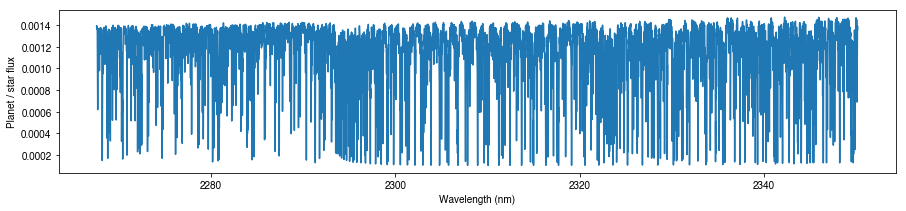

In [7]:
plt.figure(figsize=(15,3))
plt.plot(wMod, fModScaled)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Planet / star flux')
plt.show()

The factor <code><code>of 7 ensures that enough signal is obtained despite the short time sequence. Anything between 5 and 10 will work. Let's set some of the planet orbital parameters that will be useful for generating the spectral series. Users can experiment with these values to see what happens:

In [ ]:
## NOTE: These parameters are for the exoplanet HD 209458 b and they are tuned to real CRIRES observations
## of this object under realistic conditions. The observing block is about 5 hours long
Kp = 145.9               # Planet max. RV (km/s)
air = np.load('air.npy') # Airmass variation (from real observations)
ph = np.load('ph.npy')   # Orbital phases (from real observations)
rvel = np.load('rvel.npy') # Systemic + barycentric radial velocity

The first step will be to compute the planet spectral sequence by Doppler-shifting the planet spectrum based on the chose RV semi-amplitude (Kp), orbital phase (ph) and systemic + barycentric velocity. This is done by the module <code>create_planet_sequence</code> imported from <code>simulator_code.py</code>. The generated sequence will be splitted in four consecutive spectral ranges matching the format of observations with VLT/CRIRES.

In [ ]:
wFake, spcFake = sim.create_planet_sequence(wMod, fModScaled, ph, rvel, Kp)
sim.plot_matrix(wFake, spcFake, ph)

We will now load a pre-computed Earth's transmission spectrum which is found in <code>atm_trans.npy</code>. This has been computed via the ESO Sky Calculator (https://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC) by setting the water precipitable vapour to 2.5 mm and matching the airmass of the observations, however an additional scaling has been also intriduced to match the exact depth of telluric lines in a real spectral sequence of HD 209458 b. This will ensure that we are treating realistic noise signatures, and not just an idealised case.

In [ ]:
# Loading in the modelled telluric spectrum.
tell = np.load('atm_trans.npy')
print(tell.shape)
spcFake *= tell
sim.plot_matrix(wFake, spcFake, ph)

The last step involves simulating the changes in throughput (overall measured flux) as function of time due e.g. to pointing inaccuracies, varying sky transparency, etc. Once again, we measured these variations on real CRIRES data and then applied the same scaling to our simulated sequence.

In [ ]:
spcFake = sim.add_noise(spcFake)
sim.plot_matrix(wFake, spcFake, ph)